Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

Chapter 6: Using Neural Networks for Classification and Land Cover Mapping
===========================================================

Deep learning may be equal parts overhyped and underutilized (https://doi.org/10.1038/nature14539), but is undoubtedly a powerful set of tools for analyzing huge reams of data. Applications are growing rapidly in remote sensing (https://doi.org/10.1109/MGRS.2017.2762307) and in particular it is permitting new and exciting applications in areas like anomaly detection (https://doi.org/10.1109/TGRS.2018.2872509), image classification (https://doi.org/10.1109/TGRS.2016.2612821), and biophysical variable regression (https://doi.org/10.3390/rs11070768). Here we present a simple example of landcover classification using Landsat 8, the National Landcover Dataset as training data, and a simple convolutional neural network.

Small corrections and additions of missing parts by <a href="https://github.com/ClaudeCoulombe/open-geo-tutorial" target='_blank'>Claude COULOMBE - Ph.D. - Montréal</a>

### Overview

*   create utility functions
*   import data
*   import training data
*   explore the data
*   run some baseline classifications with k-nearest neighbors and random forest 
*   build a simple CNN
*   evaluate the model

##### ***Before diving into this please note that it can take much more significant computing resources to (e.g. a decent GPU) to run this code in a reasonable time. It may well run on your local computer or on Binder but if you have any issues you can simply run this in Google's Colab environment here: 

<a style="float:left;" href="https://colab.research.google.com/github/ClaudeCoulombe/open-geo-tutorial/blob/master/notebooks/chapter_6_neural_networks.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<br/><br/>
Let's start!

In [103]:
# If running this in CoLab this will be necessary to set up your VM correctly
# if so, uncomment the line below
! pip install geopandas rasterio matplotlib descartes scikit-learn

#### Dictionary of all classes and class IDs

In [104]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

print('class_names set!')


class_names set!


In [105]:
l8_path     = '/content/data/landsat_image.tif'
labels_path  = '/content/data/labels_image.tif'

#### Set random seed for reproductibility

For production or get real random behavior, just set `RANDOM_SEED = None`

In [106]:
import os

# Set a random seed
RANDOM_SEED = 21

# Set random state for Python
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Set random state for Python random function
import random
random.seed(RANDOM_SEED)

# Set random state for NumPy
import numpy as np
np.random.seed(RANDOM_SEED)

# Set random state for TensorFlow
import tensorflow as tf
tf.random.set_seed(RANDOM_SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

print("Random feed set")

Random feed set


## Download data from GitHub

In [107]:
!wget https://github.com/ClaudeCoulombe/open-geo-tutorial/blob/master/data.zip?raw=True -O data.zip


--2022-01-14 06:11:11--  https://github.com/ClaudeCoulombe/open-geo-tutorial/blob/master/data.zip?raw=True
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ClaudeCoulombe/open-geo-tutorial/raw/master/data.zip [following]
--2022-01-14 06:11:12--  https://github.com/ClaudeCoulombe/open-geo-tutorial/raw/master/data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ClaudeCoulombe/open-geo-tutorial/master/data.zip [following]
--2022-01-14 06:11:12--  https://raw.githubusercontent.com/ClaudeCoulombe/open-geo-tutorial/master/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connecte

In [108]:
import os
import zipfile

zip_ref = zipfile.ZipFile('data.zip','r')
zip_ref.extractall('.')
zip_ref.close()

### Create all the Utility Functions We'll Need:

#### First we'll create a random pixel generator for training and validation

In [109]:
import random
import math
import itertools

from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
import rasterio.features
import rasterio.warp
import rasterio.mask

from pyproj import Proj, transform
from tqdm import tqdm
from shapely.geometry import Polygon

def gen_balanced_pixel_locations(image_datasets, train_count, label_dataset, merge=False):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    label_proj = Proj(label_dataset.crs)    
    train_pixels = []
    
    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    print("train_count_per_dataset:",train_count_per_dataset)
    for index, image_dataset in enumerate(image_datasets):
        # how many points from each class
        points_per_class = train_count_per_dataset // len(np.unique(merge_classes(labels_image)))
        print("points_per_class:",points_per_class)
        # get landsat boundaries in this image
        # create approx dataset mask in geographic coords
        # this fcn maps pixel locations in (row, col) coordinates to (x, y) spatial positions
        raster_points = image_dataset.transform * (0, 0), image_dataset.transform * (image_dataset.width, 0), image_dataset.transform * (image_dataset.width, image_dataset.height), image_dataset.transform * (0, image_dataset.height)
        print("raster_points:",raster_points)
        l8_proj = Proj(image_dataset.crs)
        new_raster_points = []
        # convert the raster bounds from landsat into label crs
        for x,y in raster_points:
            x,y = transform(l8_proj,label_proj,x,y)
            # convert from crs into row, col in label image coords
            row, col = label_dataset.index(x, y)
            # don't forget row, col is actually y, x so need to swap it when we append
            new_raster_points.append((col, row))
        # turn this into a polygon
        raster_poly = Polygon(new_raster_points)
        # Window.from_slices((row_start, row_stop), (col_start, col_stop))
        masked_label_image = label_dataset.read(window=Window.from_slices((int(raster_poly.bounds[1]), int(raster_poly.bounds[3])), (int(raster_poly.bounds[0]), int(raster_poly.bounds[2]))))
        if merge:
            masked_label_image = merge_classes(masked_label_image)
        # loop for each class
        all_points_per_image = []
        # for cls in np.unique(merge_classes(labels_image)):
        progression_bar = tqdm(np.unique(merge_classes(labels_image)))
        for cls in (progression_bar):
            progression_bar.set_description("Processing « %s »" % str(class_names[int(cls)]))
            cls = int(cls)
            # mask the label subset image to each class
            # pull out the indicies where the mask is true
            rows,cols = np.where(masked_label_image[0] == cls)
            all_locations = list(zip(rows,cols))
            # shuffle all locations
            random.shuffle(all_locations)
            # now convert to landsat image crs
            # TODO need to time this to see if it is slow, can probably optimize
            l8_points = []
            # TODO Will probably need to catch this for classes smaller than the ideal points per class
            if len(all_locations)!=0:
                for r,c in all_locations[:points_per_class]:
                    # convert label row and col into label geographic space
                    x,y = label_dataset.xy(r+raster_poly.bounds[1],c+raster_poly.bounds[0])
                    # go from label projection into landsat projection
                    x,y = transform(label_proj, l8_proj,x,y)
                    # convert from landsat geographic space into row col
                    r,c = image_dataset.index(x,y)
                    l8_points.append((r,c))
                all_points_per_image += l8_points

        dataset_index_list = [index] * len(all_points_per_image)
        dataset_pixels = list(zip(all_points_per_image, dataset_index_list))
        train_pixels += dataset_pixels
        
    random.shuffle(train_pixels)
    return (train_pixels)

print('gen_balanced_pixel_locations code ready!')


gen_balanced_pixel_locations code ready!


#### Next a tile generator to take those pixel locations and build tiles of the right format. 

This generator is handed directly to the `keras` model and continually feeds data to the model during training and validation. 

In [110]:
def tile_generator(l8_image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size, merge=False):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
     
    c = r = 0
    i = 0
    
    label_proj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    l8_band_count = l8_image_datasets[0].count  
    band_count = l8_band_count
    class_count = len(class_names)
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, band_count-1)) # take one off because we don't want the QA band
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            r, c = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = l8_image_datasets[dataset_index].read(list(np.arange(1, l8_band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if tile.size == 0:
                pass
            elif np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (l8_band_count, tile_width, tile_height):
                #print('wrong shape')
                #print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print('Found some cloud.')
                #print(tile[7,:,:])
                pass
            else:                
                # taking off the QA band
                tile = tile[0:7]
                # reshape from raster format to image format and standardize according to image wide stats
                reshaped_tile = (reshape_as_image(tile)  - 982.5) / 1076.5

                ### get label data
                # find gps of that pixel within the image
                (x, y) = l8_image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                if l8_proj != label_proj:
                    x,y = transform(l8_proj,label_proj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                # label image could be huge so we need this to just get a single position
                window = ((row, row+1), (col, col+1))
                data = merge_classes(label_dataset.read(1, window=window, masked=False, boundless=True))
                label = data[0,0]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:                   
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile
                    b += 1
        yield (image_batch, label_batch)
        
print('tile_generator code ready!')


tile_generator code ready!


#### Next a function to build a more visually appealing confusion matrix than the default one.

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes, class_dict,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    # convert class_id to class_name using the class_dict
    cover_names = []
    for cover_class in classes:
        cover_names.append(class_dict[cover_class])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=cover_names, yticklabels=cover_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print('plot_confusion_matrix code ready!')


plot_confusion_matrix code ready!


#### Finally a function to merge the NLCD classes into a more manageable subset.

In [112]:
def merge_classes(y):
    # reclassify 255 to 0
    y[y == 255] = 0
    
    # group "Low Intensity Developed", "Medium Intensity Developed" and "High Intensity Developed"
    # in "Developed Land"
    y[y == 3] = 2
    y[y == 4] = 2
    class_names[2] = "Developed Land"

    # group "Open Space Developed", "Cultivated Land", and "Pasture/Hay"
    # in "Cultivated Land"
    y[y == 5] = 6
    y[y == 7] = 6
    class_names[6] = "Cultivated Land"

    # Group "Deciduous Forest","Evergreen Forest", "Scrub/Shrub"
    # and "Palustrine Forested Wetland", 
    # in "Forest Land"
    y[y == 9] = 11
    y[y == 10] = 11
    y[y == 12] = 11
    y[y == 13] = 11
    class_names[11] = "Forest Land"
    
    # Group "Palustrine Scrub/Shrub Wetland", "Palustrine Emergent Wetland", 
    # "Estuarine Forested Wetland" and "Estuarine Scrub/Shrub Wetland"
    # in "Wet Land"
    y[y == 14] = 18
    y[y == 15] = 18
    y[y == 16] = 18
    y[y == 17] = 18
    class_names[18] = "Wet Land"
    
    # Group "Unconsolidated Shore" and "Palustrine Aquatic Bed"
    # in "Water"
    y[y == 22] = 21
    y[y == 19] = 21
    class_names[21] = "Water"

    return(y)

print('merge_classes code ready!')


merge_classes code ready!


### With that out of the way let's get started!

Inspect the landsat data:

In [113]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np


# Open our raster dataset
landsat_dataset = rasterio.open(l8_path)
#
# How many bands does this image have?
num_bands = landsat_dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = landsat_dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = landsat_dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = landsat_dataset.crs
print('Image projection:')
print(proj)


Number of bands in image: 8

Image size is: 4475 rows x 1481 columns

Raster driver: GTiff

Image projection:
PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.256999999996,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


Open up the dataset and read it into memory:

In [114]:
landsat_image = landsat_dataset.read()
landsat_image.shape

(8, 4475, 1481)

Let's calculate NDVI:

In [115]:
bandNIR = landsat_image[4, :, :]
bandRed = landsat_image[3, :, :]

ndvi = np.clip((bandNIR.astype(float) - bandRed.astype(float)) / (bandNIR.astype(float) + bandRed.astype(float)), -1,1)


In [116]:
print('\nMax NDVI: {m:.2f}'.format(m=ndvi.max()))
print('Mean NDVI: {m:.2f}'.format(m=ndvi.mean()))
print('Median NDVI: {m:.2f}'.format(m=np.median(ndvi)))
print('Min NDVI: {m:.2f}'.format(m=ndvi.min()))


Max NDVI: 1.00
Mean NDVI: -0.11
Median NDVI: -0.16
Min NDVI: -1.00


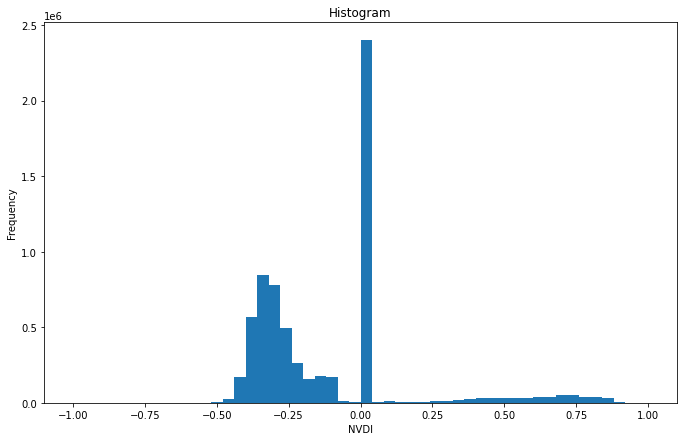

In [117]:
figure, axs = plt.subplots(figsize=(1.62*7,7))
# We can set the number of bins with the `bins` kwarg
axs.hist(ndvi.flatten(), bins=50)
plt.title("Histogram")
plt.xlabel("NVDI")
plt.ylabel("Frequency")
plt.show()


NDVI looks normal, let's check out the whole image histogram:

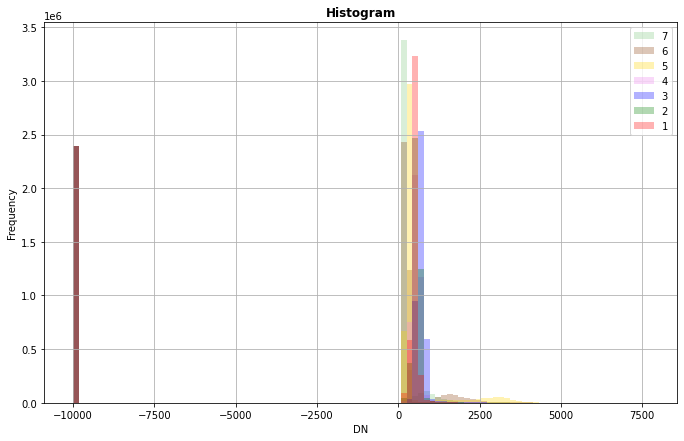

In [118]:
figure, axs = plt.subplots(figsize=(1.62*7,7))

rasterio.plot.show_hist(landsat_dataset.read([1,2,3,4,5,6,7]), 
                        bins=100, 
                        histtype='stepfilled', 
                        lw=0.0, 
                        stacked=False, 
                        alpha=0.3,
                        ax = axs,
                        title="Histogram",
                        label=[1,2,3,4,5,6,7]
                       )
axs.set_xlabel('DN')
_ = axs.set_ylabel('Frequency')


Now we'll visualize the landsat image and NDVI side by side:

(3, 4475, 1481)
(4475, 1481, 3)


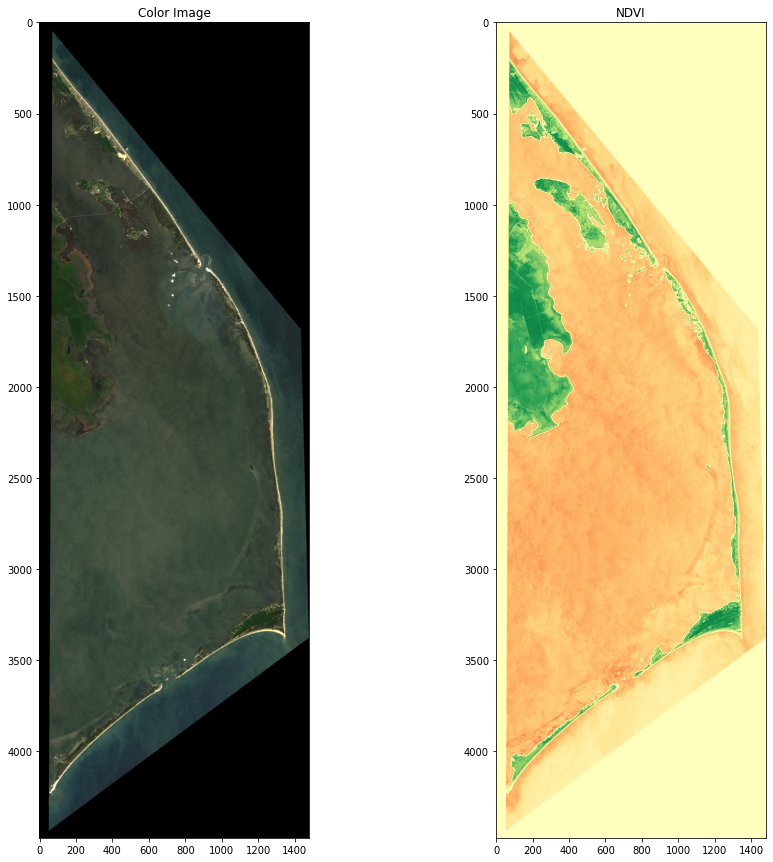

In [119]:
from rasterio.plot import adjust_band
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show

# pull out the bands we want to visualize
index = np.array([3, 2, 1])
colors = landsat_image[index, :, :].astype(np.float64)

# we'll use the values to stretch the landsat image based on the above histogram
max_val = 2500
min_val = 0

# enforce maximum and minimum values
colors[colors[:, :, :] > max_val] = max_val
colors[colors[:, :, :] < min_val] = min_val

for b in range(colors.shape[0]):
    colors[b, :, :] = colors[b, :, :] * 1 / (max_val - min_val)

# rasters are in the format [bands, rows, cols] whereas images are typically [rows, cols, bands]
# and so our array needs to be reshaped
print(colors.shape)
colors_reshaped = reshape_as_image(colors)
print(colors_reshaped.shape)

fig, axs = plt.subplots(1, 2, figsize=(15, 15)) 

# Show the color image
axs[0].imshow(colors_reshaped)
axs[0].set_title('Color Image')

# Show NDVI
axs[1].imshow(ndvi, cmap='RdYlGn')
axs[1].set_title('NDVI')

plt.show()


Now let's check out the quality band

0b0
0b1
0b101000010
0b101000100
0b101001000
0b101100000
0b110000010
0b110000100
0b110001000
0b110100000
0b111100000


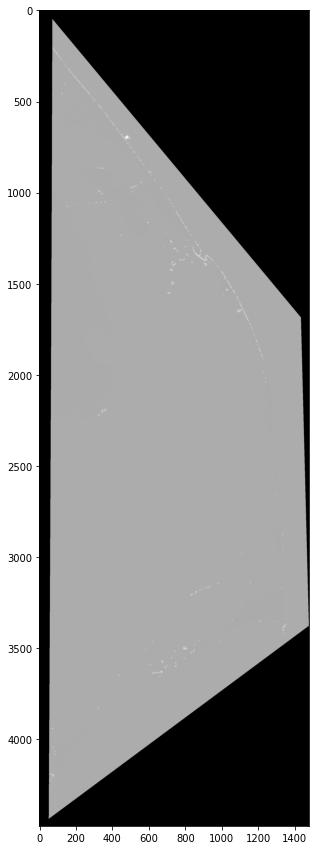

In [120]:
qa_band = landsat_image[7, :, :]
qa_band[qa_band == -9999] = 0

for i in np.unique(qa_band):
    print(bin(i))

fig, ax = plt.subplots(figsize=(15,15))
_ = ax.imshow(qa_band, cmap='gray')


#### Pull out the bit flag for water and view

In [121]:
water_bits = []

for i in qa_band.flatten():
    if bin(i) == '0b0' or bin(i) == '0b1':
        water_bits.append(0)
    else:
        water_bits.append(int(bin(i)[8]))


In [122]:
water_bits_raster = np.array(water_bits).reshape(4475, 1481)

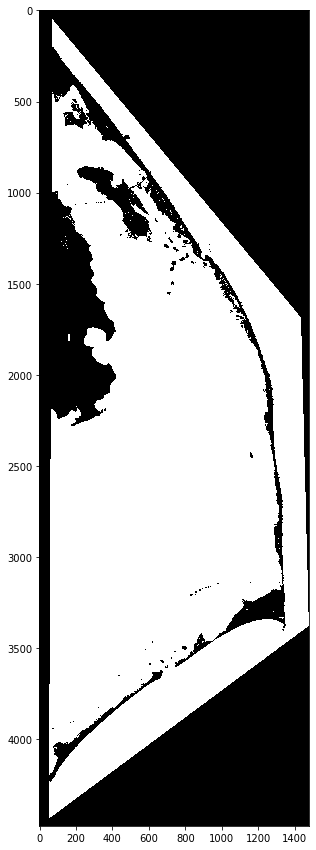

In [123]:
fig, ax = plt.subplots(figsize=(15,15))
_ = ax.imshow(water_bits_raster, cmap='gray', interpolation='None')

Read in the training labels image

In [124]:
labels_dataset = rasterio.open(labels_path)
# we're merging here just to limit the number of classes we're working with
labels_image = merge_classes(labels_dataset.read())
labels_image.shape

(1, 4476, 1482)

How many pixels are there of each class?

In [125]:
unique, counts = np.unique(labels_image, return_counts=True)
list(zip(unique, counts))

[(0, 2189505),
 (2, 53319),
 (6, 15131),
 (8, 6340),
 (11, 233678),
 (18, 272903),
 (20, 40077),
 (21, 3822479)]

In [126]:
unique, counts = np.unique(labels_image, return_counts=True)
hist_data = [(class_names[classe_id],counts) for classe_id,counts in list(zip(unique, counts))]
hist_data

[('Background', 2189505),
 ('Developed Land', 53319),
 ('Cultivated Land', 15131),
 ('Grassland', 6340),
 ('Forest Land', 233678),
 ('Wet Land', 272903),
 ('Bare Land', 40077),
 ('Water', 3822479)]

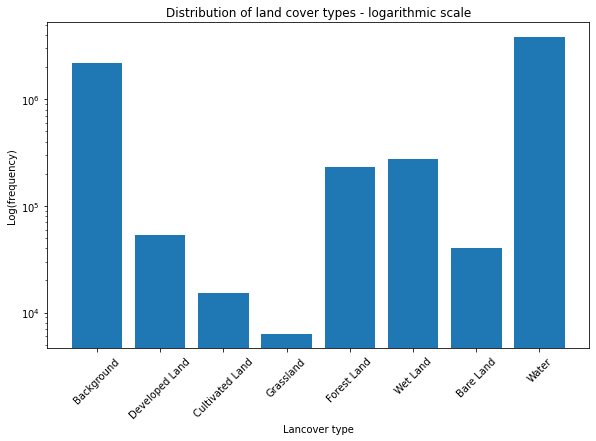

In [127]:
fig = plt.figure(figsize=(1.62*6, 6)) 
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel("Lancover type")
plt.ylabel("Log(frequency)")
plt.title("Distribution of land cover types - logarithmic scale")
_ = plt.bar([classe[0] for classe in hist_data], [classe[1] for classe in hist_data])


Let's view the training labels:

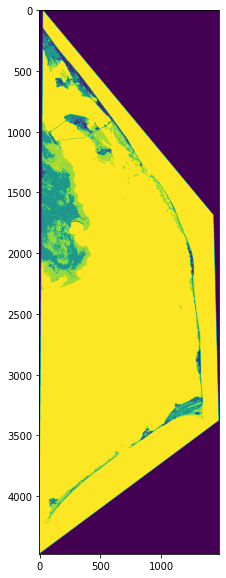

In [128]:
fig, ax = plt.subplots(figsize=(10, 10))
_ = ax.imshow(labels_image[0])

Now with a reasonable color map and compared to NDVI:


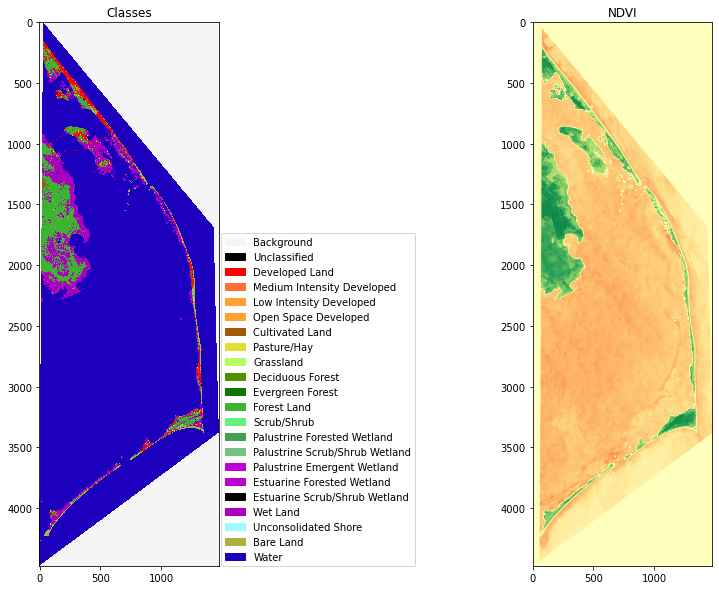

In [129]:
# next setup a colormap for our map
colors = dict((
(0, (245,245,245, 255)), # Background
(1, (0,0,0)), # Unclassified (Cloud, Shadow, etc)
(2, (255,0,0)), # High Intensity Developed
(3, (255, 110, 51)), # Medium Intensity Developed
(4, (255, 162, 51)), # Low Intensity Developed
(5, (255, 162, 51)), # Open Space Developed
(6, (162, 89, 0)), # Cultivated Land
(7, (229, 221, 50)), # Pasture/Hay
(8, (185, 251, 96)), # Grassland
(9, (83, 144, 0)), # Deciduous Forest
(10, (13, 118, 0  )), # Evergreen Forest
(11, (62, 178, 49)), # Mixed Forest
(12, (100, 241, 125)), # Scrub/Shrub
(13, (68, 160, 85)), # Palustrine Forested Wetland
(14, (118, 192, 131)), # Palustrine Scrub/Shrub Wetland
(15, (188, 0, 211)), # Palustrine Emergent Wetland
(16, (188, 0, 211)), # Estuarine Forested Wetland
(17, (0, 0, 0)), # Estuarine Scrub/Shrub Wetland
(18, (172, 0, 191)), # Estuarine Emergent Wetland
(19, (159, 251, 255)), # Unconsolidated Shore 
(20, (172, 177, 68)), # Bare Land
(21, (29, 0, 189)), # Water
(22, (40, 40, 40)), # Pal Bed
))

n = int(np.max(labels_image)) + 1


# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_false_colors = [colors[key] for key in range(0, n)]

cmap_false_colors = plt.matplotlib.colors.ListedColormap(index_false_colors, 'Classification', n)

# Now show the class map next to the RGB image

fig, ax = plt.subplots(1,2, figsize=(1.62*10,10))

import matplotlib.patches as mpatches
patches =[mpatches.Patch(color=cmap_false_colors.colors[class_id],label=class_names[class_id]) 
          for class_id in range(len(cmap_false_colors.colors))]

ax[0].imshow(labels_image[0,:, :], cmap=cmap_false_colors, interpolation='none')
ax[0].set_title('Classes')
ax[0].legend(handles=patches, loc=(1.01,0), borderaxespad=0.)

# Show NDVI
ax[1].imshow(ndvi, cmap='RdYlGn')
ax[1].set_title('NDVI')

plt.show()

### Training Data Generation

#### Generate a set of random class balanced pixel locations:

In [130]:
train_pixels = gen_balanced_pixel_locations([landsat_dataset], train_count=3000, 
                                            label_dataset=labels_dataset, merge=True)

train_count_per_dataset: 3000
points_per_class: 375
raster_points: ((1792875.0, 1650645.0), (1837305.0, 1650645.0), (1837305.0, 1516395.0), (1792875.0, 1516395.0))


Processing « Water »: 100%|██████████| 8/8 [00:55<00:00,  7.00s/it]


####  Data Sanity check
This code takes a while to run and isn't necessary to run the CNN, But it is good practice to ensure you have a balanced and correct dataset. It also is a nice sanity check to map out the actual location of the pixels.

In [131]:
# the code block below generates a ton of warnings so we'll supress them for now
import warnings
warnings.filterwarnings("ignore")

In [132]:
landsat_datasets = [landsat_dataset]
# generate the training and validation pixel locations
all_labels = []
label_locations = []
progression_bar = tqdm(train_pixels)
for index,pixel in enumerate(progression_bar):
    progression_bar.set_description("Processing data point: %s" % str(index))

    # row, col location in landsat
    r,c = pixel[0]
    ds_index = pixel[1]
    l8_proj = Proj(landsat_datasets[ds_index].crs)
    label_proj = Proj(labels_dataset.crs)
    
    # geographic location in landsat
    x,y = landsat_datasets[ds_index].xy(r,c)
    # go from label projection into landsat projection
    x,y = transform(l8_proj, label_proj ,x,y)
    # get row and col location in label
    r,c = labels_dataset.index(x,y)
    
    label_locations.append([r,c])
    
    # format (bands, height, width)
    window = ((r, r+1), (c, c+1))
    data = merge_classes(labels_dataset.read(1, window=window, masked=False, boundless=True))
    all_labels.append(data[0,0])
    
label_locations = np.array(label_locations)

unique, counts = np.unique(np.array(all_labels), return_counts=True)
dict(zip(unique, counts))

Processing data point: 2999: 100%|██████████| 3000/3000 [01:20<00:00, 37.41it/s]


{0: 375, 2: 375, 6: 375, 8: 375, 11: 375, 18: 375, 20: 375, 21: 375}

#### Data location vizualization

Now show the class map next to the location of training pixels on the image

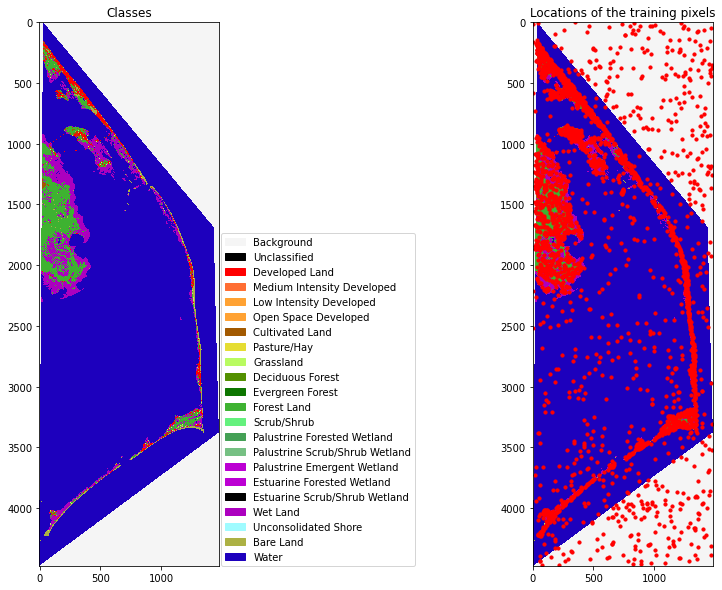

In [133]:
fig, axs = plt.subplots(1,2,figsize=(1.62*10,10))

# location of training pixels on the image
_ = axs[0].imshow(labels_image[0,:, :],
                  cmap=cmap_false_colors, 
                   interpolation='none')
axs[0].legend(handles=patches, loc=(1.01,0), borderaxespad=0.)
axs[0].set_title('Classes')

axs[1].imshow(labels_image[0,:, :],
               cmap=cmap_false_colors, 
               interpolation='none')
axs[1].scatter(label_locations[:, 1],label_locations[:, 0], 
                s=10, 
                c='r')
axs[1].set_title("Locations of the training pixels")

plt.show()

Note that there are lots of pixels generated in areas that don't actually have data. We'll filter that out in the data generator.

#### Test out the generator:

Print out some image and label batches and check out their shapes.

In [134]:
im_batch = None

count = 0
for (im, label) in tile_generator(landsat_datasets, labels_dataset, 128, 128, train_pixels, 10):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

Image
(10, 128, 128, 7)
Label
(10, 26)
----
Image
(10, 128, 128, 7)
Label
(10, 26)
----
Image
(10, 128, 128, 7)
Label
(10, 26)
----
Image
(10, 128, 128, 7)
Label
(10, 26)
----


#### Tiles Visualization

Now let's visualize the actual tiles. Note they'll look unnatural because they have been normalized.

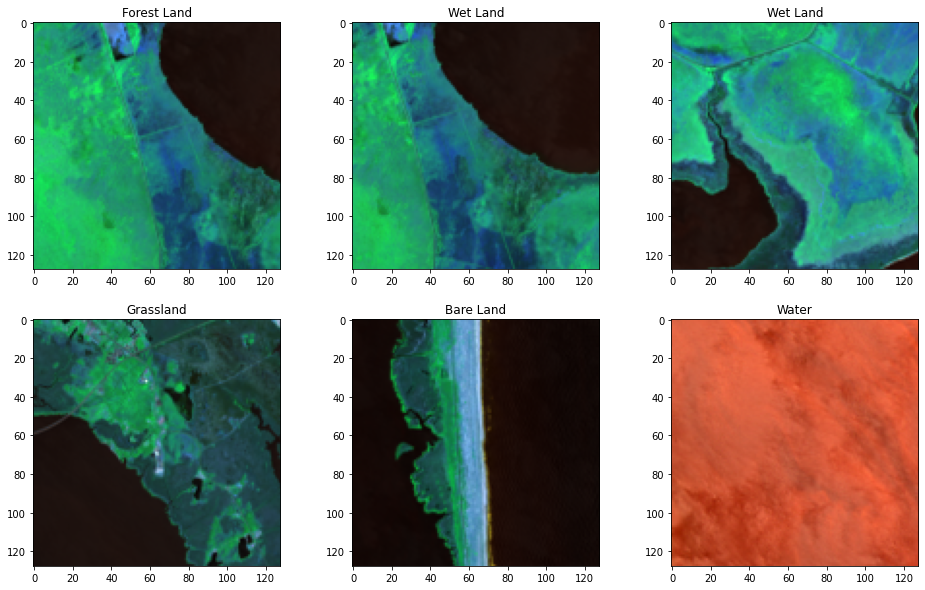

In [135]:
import numpy as np

def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

fig, axes = plt.subplots(2, 3, figsize=(1.62*10, 10)) 
axes[0,0].imshow(normalize(im_batch[0,:,:,3:6]))
axes[0,0].set_title(class_names[np.argmax(label_batch[0])])
axes[0,1].imshow(normalize(im_batch[1,:,:,3:6]))
axes[0,1].set_title(class_names[np.argmax(label_batch[1])])
axes[0,2].imshow(normalize(im_batch[2,:,:,3:6]))
axes[0,2].set_title(class_names[np.argmax(label_batch[2])])
axes[1,0].imshow(normalize(im_batch[3,:,:,3:6]))
axes[1,0].set_title(class_names[np.argmax(label_batch[3])])
axes[1,1].imshow(normalize(im_batch[4,:,:,3:6]))
axes[1,1].set_title(class_names[np.argmax(label_batch[4])])
axes[1,2].imshow(normalize(im_batch[5,:,:,3:6]))
axes[1,2].set_title(class_names[np.argmax(label_batch[5])])

plt.show()


### Generate training dataset of 1x1 tiles for scikit-learn to visualize data

In [136]:
im_batch = None
label_batch = None

sample_size = 500

count = 0
for (im, label) in tile_generator(landsat_datasets, 
                                  labels_dataset, 
                                  1, 1, 
                                  train_pixels, 
                                  sample_size):
    if count > 0:
        break
    print('Batch Shape')
    print(im.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

Batch Shape
(500, 1, 1, 7)
Label Shape
(500, 26)
----


#### Reshape Data

Reshape because scikit-learn needs data in `(samples, bands)` format:

In [137]:
im_batch[0,:,:,:]

array([[[-0.45, -0.34, -0.15, -0.19, -0.65, -0.73, -0.77]]])

In [138]:
im_batch_reshaped = im_batch.reshape(sample_size,7)
im_batch_reshaped[0]

array([-0.45, -0.34, -0.15, -0.19, -0.65, -0.73, -0.77])

#### Visualize Spectral Signatures

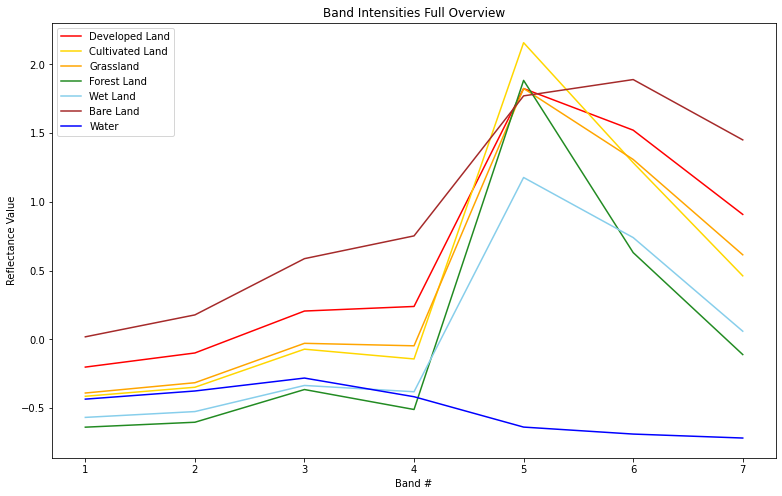

In [139]:
fig, ax = plt.subplots(1,1, figsize=[1.62*8,8])

colors = ['red', # 'Developed Land' 2
          'gold', # 'Cultivated Land' 6
          'orange', # 'Grassland' 8
          'forestgreen', # 'Forest Land' 11
          'skyblue', # 'Wet Land' 18
          'brown', # 'Bare Land' 20
          'blue'] # Water 21

# numbers 1-8
band_count = np.arange(1,8)

y = np.argmax(label_batch, axis=1)
X = im_batch_reshaped

classes = np.unique(y)
for index_color,class_type in enumerate(classes):  
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax.plot(band_count,
            band_intensity, 
            color=colors[index_color], 
            label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')

# Add a title
ax.set_title('Band Intensities Full Overview')
_ = ax.legend(loc='upper left')

#### Run Principle Components Analysis to visualize points

In [140]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca_result = pca.fit_transform(im_batch_reshaped)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

df = pd.DataFrame({'pca-one':pca_result[:,0],'pca-two':pca_result[:,1],'pca-three':pca_result[:,2], 'y' : np.argmax(label_batch, axis=1)})


Explained variation per principal component: [0.78 0.18 0.03]


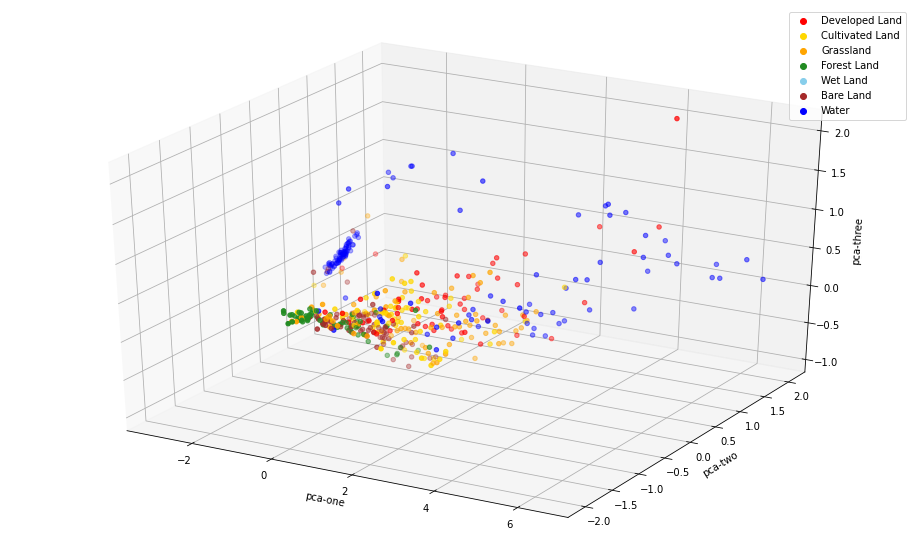

In [141]:
fig = plt.figure(figsize=(1.62*10,10))
ax = fig.add_subplot(projection='3d')

legend = []
for class_type in classes:
    legend.append(class_names[class_type])

colors = ['red', # 'Developed Land' 2
          'gold', # 'Cultivated Land' 6
          'orange', # 'Grassland' 8
          'forestgreen', # 'Forest Land' 11
          'skyblue', # 'Wet Land' 18
          'brown', # 'Bare Land' 20
          'blue'] # Water 21

my_cmap = plt.matplotlib.colors.ListedColormap(colors)

ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["y"], 
    cmap=my_cmap
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')


import matplotlib
colors_replacement_list = []
for color in colors:
    colors_replacement_list.append(matplotlib.lines.Line2D([0],[0],
                                                           linestyle="none",
                                                           c=color,
                                                           marker = 'o'))
ax.legend(colors_replacement_list, legend, numpoints = 1)

plt.show()

#### Run T-distributed Stochastic Neighbor Embedding (t-SNE) to visualize points

In [142]:
from time import time
from sklearn.manifold import TSNE

time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(im_batch_reshaped)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.631195
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.874046
[t-SNE] KL divergence after 1000 iterations: 0.170707
t-SNE done! Time elapsed: 4.151252746582031 seconds


In [143]:
df_subset = df.copy()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

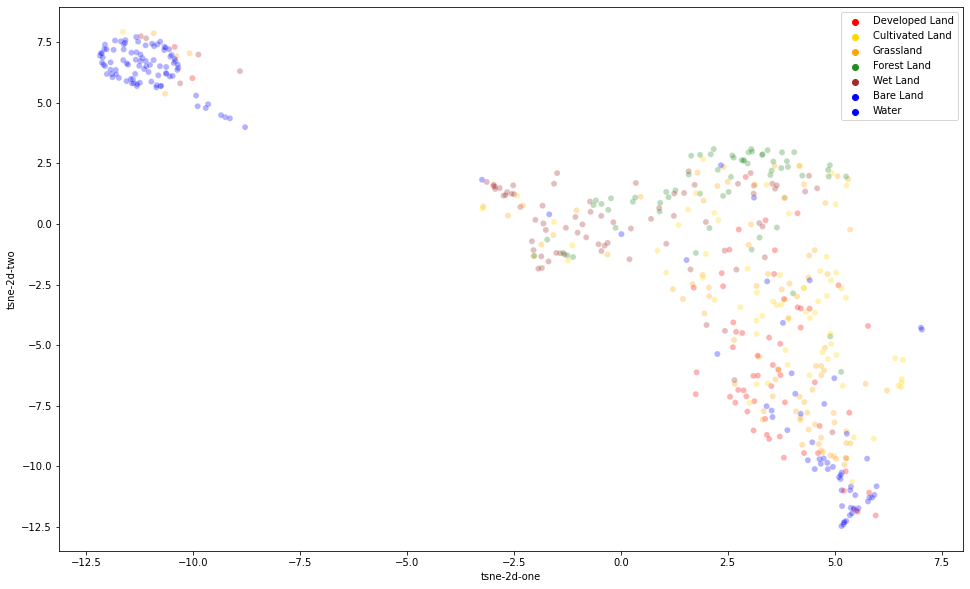

In [144]:
colors = ['red', # 'Developed Land' 2
          'gold', # 'Cultivated Land' 6
          'orange', # 'Grassland' 8
          'forestgreen', # 'Forest Land' 11
          'skyblue', # 'Wet Land' 18
          'brown', # 'Bare Land' 20
          'blue'] # Water 21

my_cmap = plt.matplotlib.colors.ListedColormap(colors)

fig, ax = plt.subplots(1,1, figsize=[1.62*10,10])
_ = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                    hue="y",
                    palette=my_cmap,
                    data=df_subset,
                    legend="full",
                    alpha=0.3
)

my_legend = ax.legend()
my_legend.get_texts()[0].set_text('Developed Land')
my_legend.get_texts()[1].set_text('Cultivated Land')
my_legend.get_texts()[2].set_text('Grassland')
my_legend.get_texts()[3].set_text('Forest Land')
my_legend.get_texts()[4].set_text('Wet Land')
my_legend.get_texts()[5].set_text('Bare Land')
my_legend.get_texts()[6].set_text('Water')


## Creation of a Baseline for Landcover Classification 

### Generate training dataset of 1x1 tiles for scikit-learn to use in Random Forest and KNN

In [145]:
im_batch = None
label_batch = None

sample_size = 800
train_count = 600

count = 0
for (im, label) in tile_generator(landsat_datasets, labels_dataset, 1, 1, train_pixels, sample_size):
    if count > 0:
        break
    print('Batch Shape')
    print(im.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

im_batch_reshaped = im_batch.reshape(sample_size,7)

X_train = im_batch_reshaped[:train_count]
X_val = im_batch_reshaped[train_count:]
y_train = np.argmax(label_batch, axis=1)[:train_count]
y_val = np.argmax(label_batch, axis=1)[train_count:]

Batch Shape
(800, 1, 1, 7)
Label Shape
(800, 26)
----


### Run K Nearest Neighbors

In [146]:
from sklearn import neighbors, datasets

n_neighbors = 20

clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X_train, y_train)

print('Accuracy: {accuracy:.2f}%'.format(accuracy = clf.score(X_val, y_val)*100))

Accuracy: 54.50%


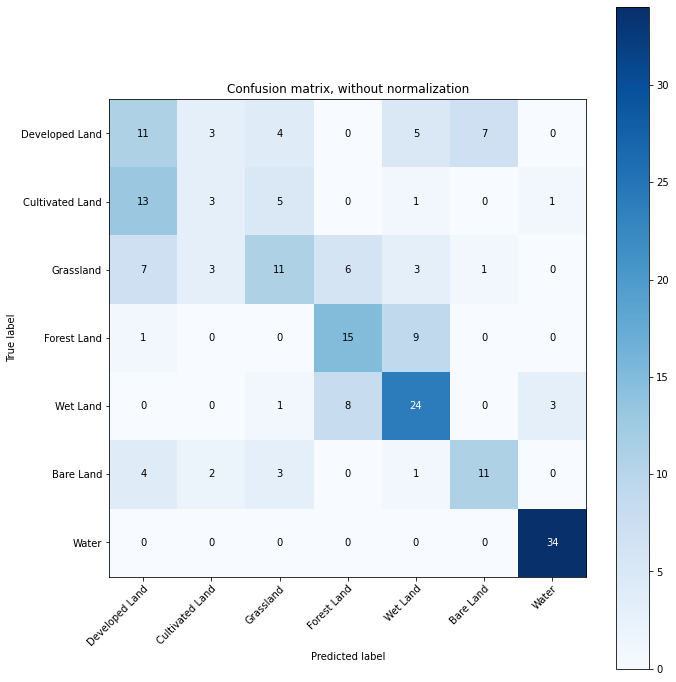

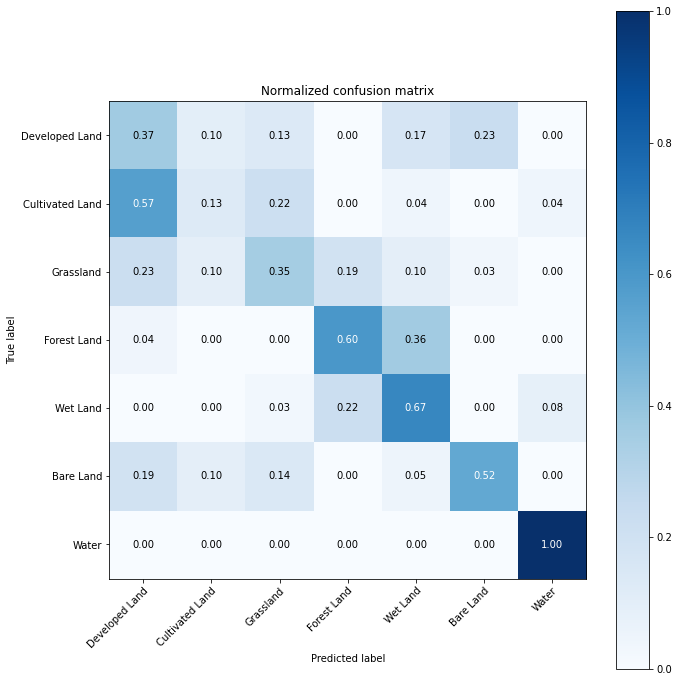

In [147]:
pred_index = clf.predict(X_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
_ = plot_confusion_matrix(y_val, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [148]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
print("Accuracy: {accuracy:.2f}%".format(accuracy = accuracy_score(y_val, pred_index)*100)) 
print("Precision: {precision:.2f}%".format(precision = precision_score(y_val, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall = recall_score(y_val, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1 = f1_score(y_val, pred_index, average='weighted')*100))


Accuracy: 54.50%
Precision: 52.63%
Recall: 54.50%
F1 score: 52.94%


### Run Random Forest

In [149]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, 
                            oob_score=True)

# Fit our model to training data
rf = rf.fit(X_train, y_train)

print('Our OOB prediction of accuracy is: {oob:.2f}%'.format(oob=rf.oob_score_*100))

print('Acccuracy: {accuracy:.2f}%'.format(accuracy = rf.score(X_val, y_val)*100))

Our OOB prediction of accuracy is: 60.17%
Acccuracy: 55.50%


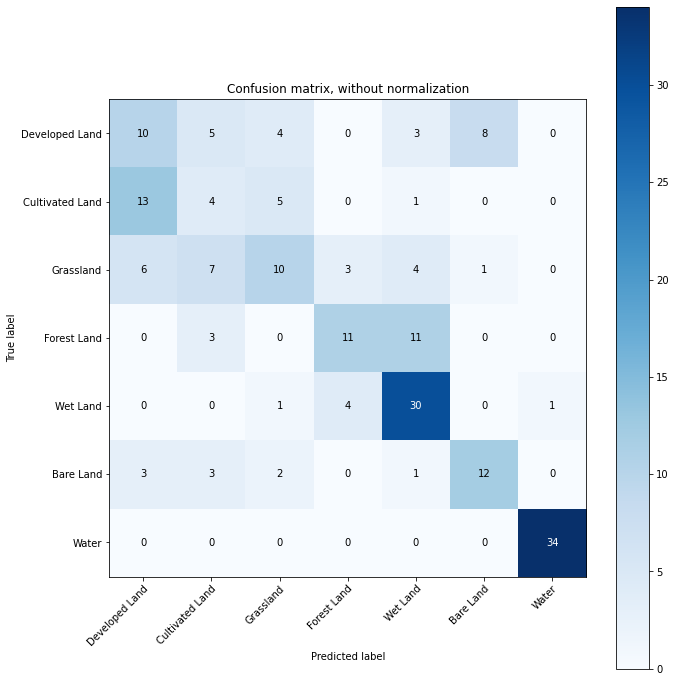

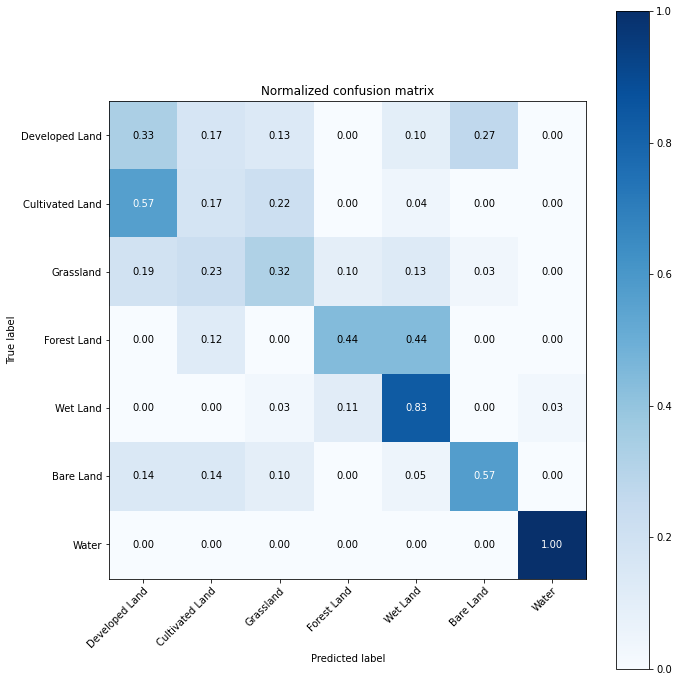

In [150]:
pred_index = rf.predict(X_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
_ = plot_confusion_matrix(y_val, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [151]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
print("Accuracy: {accuracy:.2f}%".format(accuracy = accuracy_score(y_val, pred_index)*100)) 
print("Precision: {precision:.2f}%".format(precision = precision_score(y_val, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall = recall_score(y_val, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1 = f1_score(y_val, pred_index, average='weighted')*100))


Accuracy: 55.50%
Precision: 54.78%
Recall: 55.50%
F1 score: 54.44%


These models aren't terrible but they do mis-classify a good deal of the grassland, cultivated land, and developed land. Let's see if we can improve it!

## Building the actual neural network model

Import all the necessary `keras` packages

In [152]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint

Set the hyperparameters

In [165]:
batch_size = 25
epochs = 50
num_classes = len(class_names)

# input image dimensions
tile_side = 32
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count- 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(32, 32, 7)


### Create the CNN architecture:

In [166]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(num_classes))
model.add(Activation('softmax'))

print("\nModel architecture:\n")
model.summary()


Model architecture:

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        2048      
                                                                 
 batch_normalization_14 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_15 (Bat  (N

### Decide on the metrics and compile the model:

In [167]:
metrics=['accuracy']

model.compile(loss='categorical_crossentropy', metrics=metrics)

print("Model compiled")

Model compiled


### Divide data into training and validation:

In [168]:
train_to_val_ratio = 0.8
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]
print("# Training samples: {n_training} \n# Validation samples: {n_val}".
      format(n_training=len(train_px),n_val=len(val_px)))

# Training samples: 2400 
# Validation samples: 600


### Train the model:

<img src="https://i.imgur.com/vFCeROF.png" alt="drawing" width="500"/>

Image from the excellent *Deep Learning with Python* by François Chollet

This may take some time to start up and will take a minute or two to actually run. If you're not on a GPU machine this will take a lot longer.

In [169]:
history = model.fit_generator(generator=tile_generator(landsat_datasets, 
                                                       labels_dataset, 
                                                       tile_side, tile_side, 
                                                       train_px, 
                                                       batch_size, 
                                                       merge=True), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_generator(landsat_datasets,
                                                   labels_dataset,
                                                   tile_side, tile_side,
                                                   val_px,
                                                   batch_size,
                                                   merge=True),
                    validation_steps=len(val_px) // batch_size)


Epoch 1/50
96/96 [==============================] - 9s 73ms/step - loss: 1.4032 - accuracy: 0.5362 - val_loss: 1.6388 - val_accuracy: 0.4500
Epoch 2/50
96/96 [==============================] - 7s 71ms/step - loss: 1.0738 - accuracy: 0.5767 - val_loss: 1.2367 - val_accuracy: 0.5217
Epoch 3/50
96/96 [==============================] - 7s 72ms/step - loss: 0.9696 - accuracy: 0.6146 - val_loss: 1.1725 - val_accuracy: 0.5633
Epoch 4/50
96/96 [==============================] - 7s 72ms/step - loss: 0.8704 - accuracy: 0.6587 - val_loss: 1.0432 - val_accuracy: 0.6033
Epoch 5/50
96/96 [==============================] - 7s 71ms/step - loss: 0.7801 - accuracy: 0.6854 - val_loss: 1.0517 - val_accuracy: 0.6183
Epoch 6/50
96/96 [==============================] - 7s 70ms/step - loss: 0.6589 - accuracy: 0.7508 - val_loss: 1.2930 - val_accuracy: 0.5517
Epoch 7/50
96/96 [==============================] - 7s 70ms/step - loss: 0.5585 - accuracy: 0.7875 - val_loss: 1.0207 - val_accuracy: 0.6383
Epoch 8/50
96

### Display of training and validation curves

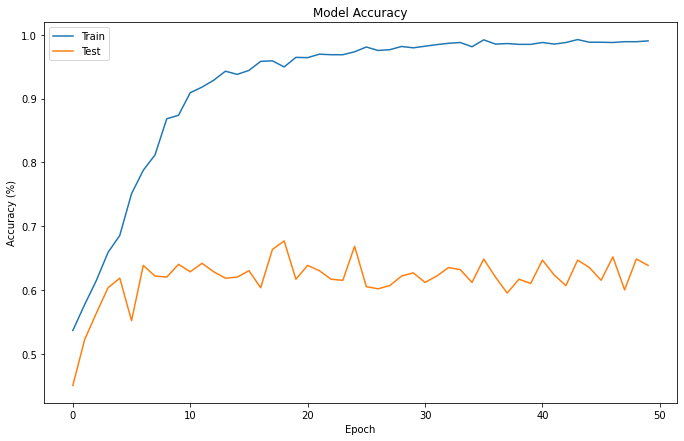

In [170]:
plt.figure(figsize=(1.62*7,7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
_ = plt.legend(['Train', 'Test'], loc='upper left')

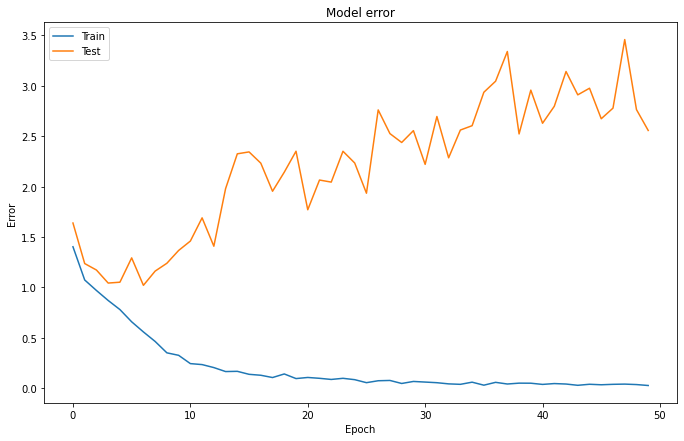

In [171]:
plt.figure(figsize=(1.62*7,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model error")
plt.ylabel("Error")
plt.xlabel("Epoch")
_ = plt.legend(['Train', 'Test'], loc='upper left')

Hopefully we found our way down here:

<img src="https://github.com/patrickcgray/open-geo-tutorial/blob/master/data/nonconvex3.jpg?raw=true" alt="drawing" width="500"/>

Image from: http://doi.org/10.1126/science.360.6388.478

#### Check out testing accuracy based on a confusion matrix:

24/24 [==============================] - 1s 53ms/step


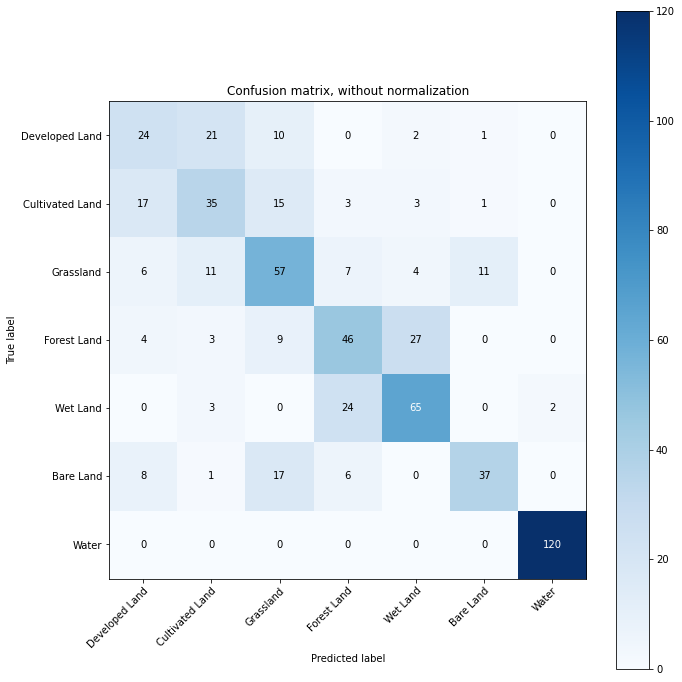

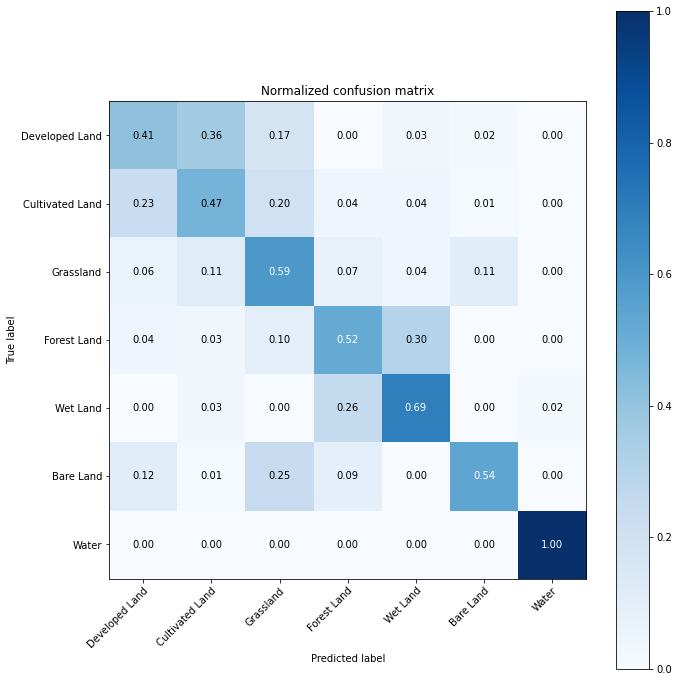

In [172]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, val_px, batch_size, merge=True), 
                        steps=len(val_px) // batch_size,
                         verbose=1)

eval_generator = tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, val_px, batch_size=1, merge=True)

labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1
    
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
_ = plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [173]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
print("Accuracy: {accuracy:.2f}%".format(accuracy = accuracy_score(label_index, pred_index)*100)) 
print("Precision: {precision:.2f}%".format(precision = precision_score(label_index, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall = recall_score(label_index, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1 = f1_score(label_index, pred_index, average='weighted')*100))


Accuracy: 64.00%
Precision: 64.41%
Recall: 64.00%
F1 score: 63.97%


Not too bad! About 10% improvement for CNN over more classical machine learning algoritms. 

#### Check out training accuracy based on a confusion matrix:

How well does the model predict on the training data?

96/96 [==============================] - 5s 52ms/step


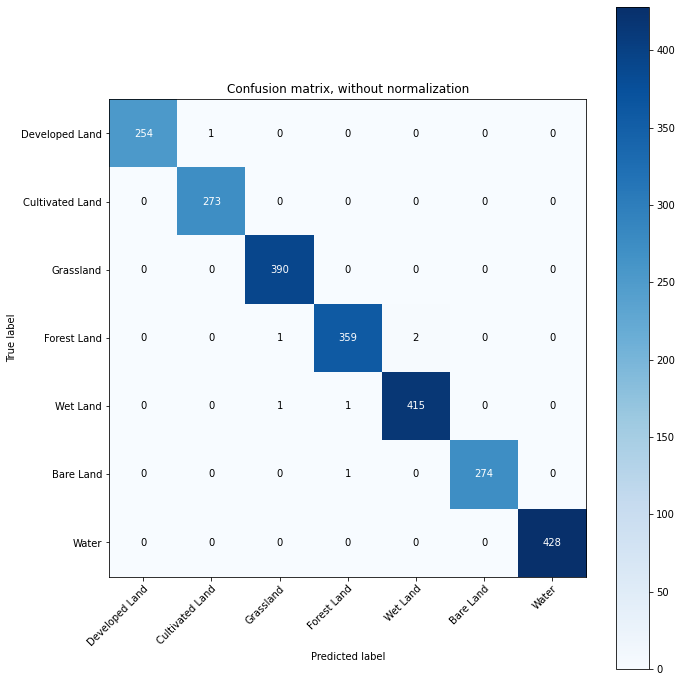

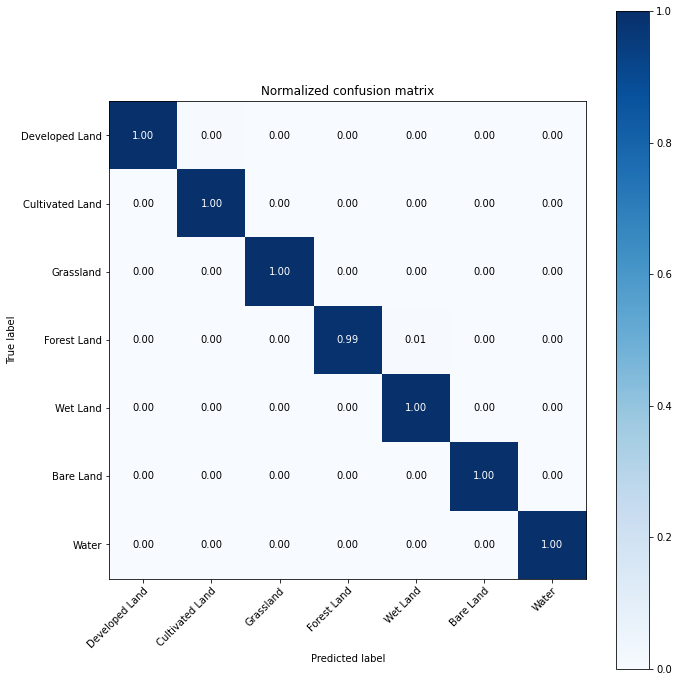

In [174]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, train_px, batch_size, merge=True), 
                        steps=len(train_px) // batch_size,
                         verbose=1)

eval_generator = tile_generator(landsat_datasets, labels_dataset, tile_side, tile_side, train_px, batch_size=1, merge=True)

labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1
    
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
_ = plot_confusion_matrix(label_index, pred_index, 
                          classes=np.array(list(class_names)),
                          class_dict=class_names)

# Plot normalized confusion matrix
_ = plot_confusion_matrix(label_index, pred_index, 
                          classes=np.array(list(class_names)),
                          class_dict=class_names,
                          normalize=True)

In [175]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
print("Accuracy: {accuracy:.2f}%".format(accuracy = accuracy_score(label_index, pred_index)*100)) 
print("Precision: {precision:.2f}%".format(precision = precision_score(label_index, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall = recall_score(label_index, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1 = f1_score(label_index, pred_index, average='weighted')*100))


Accuracy: 99.71%
Precision: 99.71%
Recall: 99.71%
F1 score: 99.71%


Given how well it does on the training compared to validation data certainly hints at overfitting. We need to train it on more data!

## Wrapup

We've now played with a number of data exploration techniques and seen how we can use `keras` to build a deep neural network for effective landcover classification. No small feat!

In the next chapter (link to [webpage](chapter_7_earth_engine_oceanography.html) or [Notebook](chapter_7_earth_engine_oceanography.ipynb)) we'll explore how we can use Google Earth Engine to process and download imagery for time series analysis.

In [164]:
print("IPython Notebook execution completed!")

IPython Notebook execution completed!
